In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
# Import KNeighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier
# To evaluate our model
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [2]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [3]:
data1 = pd.read_csv('/content/gdrive/My Drive/selected_dataset/drugsComTrain_raw.csv')

In [4]:
data2 = pd.read_csv("/content/gdrive/My Drive/selected_dataset/drugsComTest_raw.csv")

In [5]:
data = pd.concat([data1,data2])[['review','condition']]

In [6]:
data.head()

,review,condition
0,"""It has no side effect, I take it in combinati...",Left Ventricular Dysfunction
1,"""My son is halfway through his fourth week of ...",ADHD
2,"""I used to take another oral contraceptive, wh...",Birth Control
3,"""This is my first time using any form of birth...",Birth Control
4,"""Suboxone has completely turned my life around...",Opiate Dependence


In [7]:
# remove NULL Values from data
data = data[pd.notnull(data['review'])]

In [8]:
data['len'] = data['review'].apply(lambda s : len(s))

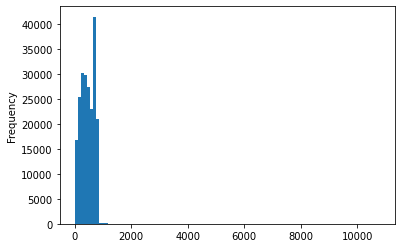

In [9]:
data['len'].plot.hist(bins=100)

In [10]:
data.len.quantile(0.9)

758.0

In [11]:
count_df = data[['condition','review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review',ascending=False)
count_df.head()

,condition,review
175,Birth Control,38436
273,Depression,12164
613,Pain,8245
133,Anxiety,7812
87,Acne,7435


In [12]:
target_conditions = count_df[count_df['review']>3000]['condition'].values

In [13]:
def condition_parser(x):
    if x in target_conditions:
        return x
    else:
        return "OTHER"
    
data['condition'] = data['condition'].apply(lambda x: condition_parser(x))  

In [14]:
data = data[data['condition']!='OTHER']

In [15]:
import plotly.express as px

In [16]:
px.bar(count_df[count_df['review']>3000],x='condition',y='review')

In [17]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [18]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")

'this is a text with contraction'

In [19]:
# lower the text
data["review"] = data["review"].apply(lambda x: x.lower())

# Clean the text
data["review"] = data["review"].apply(lambda x: clean_text(x))

# Clean numbers
data["review"] = data["review"].apply(lambda x: clean_numbers(x))

# Clean Contractions
data["review"] = data["review"].apply(lambda x: replace_contractions(x))


In [20]:
data['condition'].unique()

array(['ADHD', 'Birth Control', 'Emergency Contraception',
       'Bipolar Disorde', 'Depression', 'Obesity', 'Insomnia',
       'Vaginal Yeast Infection', 'Pain', 'Diabetes, Type 2', 'Anxiety',
       'Acne', 'High Blood Pressure', 'Weight Loss'], dtype=object)

In [21]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['review'], data['condition'],
                                                    stratify=data['condition'], 
                                                    test_size=0.25)

In [22]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (83673,)
Test shape :  (27891,)


In [23]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [25]:
le.classes_

array(['ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde', 'Birth Control',
       'Depression', 'Diabetes, Type 2', 'Emergency Contraception',
       'High Blood Pressure', 'Insomnia', 'Obesity', 'Pain',
       'Vaginal Yeast Infection', 'Weight Loss'], dtype=object)

In [26]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index):
    EMBEDDING_FILE = '/content/gdrive/My Drive/selected_dataset/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [27]:

if debug:
    embedding_matrix = np.random.randn(120000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [28]:
np.shape(embedding_matrix)

(30942, 300)

In [29]:
neigh = KNeighborsClassifier(5)

neigh.fit (train_X, train_y)

predictions = neigh.predict (test_X)

print ("Accuracy:", accuracy_score (test_y, predictions))

cm = confusion_matrix(test_y, predictions)
print("Confusion Matrix\n")
print(cm)

cr = classification_report(test_y, predictions)
print("\n\nClassification Report\n")
print(cr)

Accuracy: 0.3069090387580223
Confusion Matrix

[[ 152   67   66   46  537   88   11   18   21   31   14   43   13   20]
 [  60  292  133   66  947  130   23   27   19   43   32   60   14   13]
 [  80  144  311   86  886  145   31   30   34   37   39   91   14   25]
 [  68  100  114  160  645  100   20   18   18   35   22   63    6   32]
 [ 242  465  587  360 6672  473   81  100   91  143   86  215   23   71]
 [ 121  211  279  134 1462  449   36   51   30   72   39  110   10   37]
 [  45   85   74   44  365   79   41   10   12   16   11   36    6   17]
 [  34   58   60   40  468   49    6   42    7   16    8   20    4   11]
 [  34   62   89   40  343   71   12    9   36   17   11   38    2   12]
 [  61   96  108   70  561  101   23   20   18   79   13   53    7   16]
 [  48   96  101   64  585   94   17   18   11   19   60   54    4   18]
 [ 104  150  171  130  858  167   50   38   44   54   44  219    7   25]
 [  38   59   62   48  390   67   19   12    8   14   14   25    6    9]
 [  